In [1]:
import sys
sys.path.append('..')

In [2]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from library.data.relationship_matrix import relationship_matrix

from library.solution import Solution
from library.custom.custom_solutions import WSOSolution, WSOGASolution

from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm
from library.algorithms.genetic_algorithms.selection import fitness_proportionate_selection
from library.custom.custom_crossover import cycle_crossover, partially_matched_crossover, pos_based_crossover
from library.custom.custom_mutation import block_swap_mutation, n_swap_mutation, displacement_mutation, shuffle_subsequence_mutation
from library.custom.custom_selection import tournament_selection, ranking_selection

## Utility functions

In [3]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

## Global parameters

In [4]:
POP_SIZE = 50
GENERATIONS = 100
NBR_RUNS = 1

## Experiment Run

In [5]:
grid_params = {
    "crossover": [
        {
            "function": cycle_crossover,
            "xo_prob": 0.8
        },
        {
            "function": partially_matched_crossover,
            "xo_prob": 0.8
        },
        {
            "function": pos_based_crossover,
            "xo_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": block_swap_mutation,
            "mut_prob": 0.2
        },
        {
            # lower mutation probability than labs becuase n-swap is more disruptive than swap
            "function": n_swap_mutation,
            "mut_prob": 0.2
        },
        {
            "function": displacement_mutation,
            "mut_prob": 0.2
        },
        {
            "function": shuffle_subsequence_mutation,
            "mut_prob": 0.2
        }
    ],
    "selection": [tournament_selection, fitness_proportionate_selection, ranking_selection]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))

for crossover_cfg, mutation_cfg, selection_algorithm in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 100

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]

    # Run for predefined x times
    for run_nr in range(NBR_RUNS):
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                WSOGASolution(
                    relationship_matrix=relationship_matrix,
                    mutation_function=mutation_function,
                    crossover_function=crossover_function,  
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=selection_algorithm,
            maximization=True,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=True
        )

        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_"
        f"{selection_algorithm.__name__}"
    )

    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df

In [6]:
print(list(fitness_dfs.keys()))

['cycle_crossover0.8_block_swap_mutation0.2_tournament_selection', 'cycle_crossover0.8_block_swap_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_block_swap_mutation0.2_ranking_selection', 'cycle_crossover0.8_n_swap_mutation0.2_tournament_selection', 'cycle_crossover0.8_n_swap_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_n_swap_mutation0.2_ranking_selection', 'cycle_crossover0.8_displacement_mutation0.2_tournament_selection', 'cycle_crossover0.8_displacement_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_displacement_mutation0.2_ranking_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_fitness_proportionate_selection', 'cycle_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection', 'partially_matched_crossover0.8_block_swap_mutation0.2_tournament_selection', 'partially_matched_crossover0.8_block_swap_mutation0.2_fitness_proportionate

In [11]:
fitness_dfs["partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection"]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,21700,24700,24700,24700,24700,24700,27800,27800,27800,31400,...,51200,51200,51200,51200,51200,51200,51200,51200,51200,51200


Top 8 configurations sorted desc:
partially_matched_crossover0.8_displacement_mutation0.2_ranking_selection: 51200.0
cycle_crossover0.8_n_swap_mutation0.2_fitness_proportionate_selection: 49900.0
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_ranking_selection: 48900.0
partially_matched_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: 48600.0
pos_based_crossover0.8_shuffle_subsequence_mutation0.2_tournament_selection: 48500.0
cycle_crossover0.8_shuffle_subsequence_mutation0.2_fitness_proportionate_selection: 48400.0
partially_matched_crossover0.8_n_swap_mutation0.2_tournament_selection: 48100.0
cycle_crossover0.8_n_swap_mutation0.2_ranking_selection: 46600.0


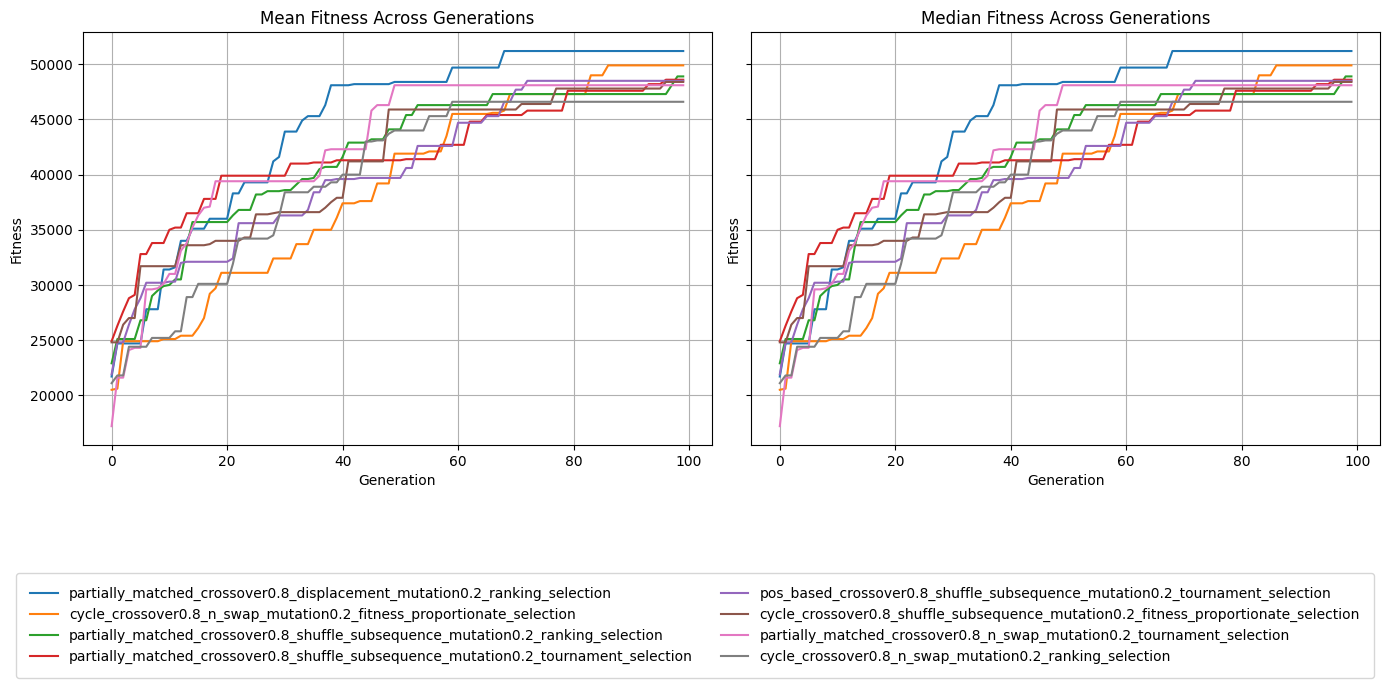

In [ ]:
# Select the top 8 configurations with the highest mean fitness in the last generation
last_gen_fitness = {
    config: df[GENERATIONS - 1].mean() for config, df in fitness_dfs.items()
}

# Sort descending and take the top 8
top_configs = sorted(last_gen_fitness, key=last_gen_fitness.get, reverse=True)[:8]

print("Top 8 configurations sorted desc:")
for config in top_configs:
    print(f"{config}: {last_gen_fitness[config]}")

# Dictionary for plotting
top_fitness_dfs = {config: fitness_dfs[config] for config in top_configs}
plot_fitness_over_gen(top_fitness_dfs)